# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head(10)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
5,1,Internet,RoundTrip,3,48,20,Thu,AKLDEL,New Zealand,1,0,1,5.52,0
6,3,Internet,RoundTrip,201,33,6,Thu,AKLDEL,New Zealand,1,0,1,5.52,0
7,2,Internet,RoundTrip,238,19,14,Mon,AKLDEL,India,1,0,1,5.52,0
8,1,Internet,RoundTrip,80,22,4,Mon,AKLDEL,New Zealand,0,0,1,5.52,0
9,1,Mobile,RoundTrip,378,30,12,Sun,AKLDEL,India,0,0,0,5.52,0


In [3]:
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")

Dataset Shape: (50000, 14)

First 5 rows:


In [4]:
# ==========================================
# 1. EXPLORATORY DATA ANALYSIS
# ==========================================

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic information about the dataset
print("\nDataset Info:")
print(df.info())


EXPLORATORY DATA ANALYSIS

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [9]:
# Target variable distribution
print("\nTarget Variable Distribution:")
print(df['booking_complete'].value_counts())
print(f"Booking completion rate: {df['booking_complete'].mean():.2%}")


Target Variable Distribution:
booking_complete
0    42522
1     7478
Name: count, dtype: int64
Booking completion rate: 14.96%


## Data Vizualization


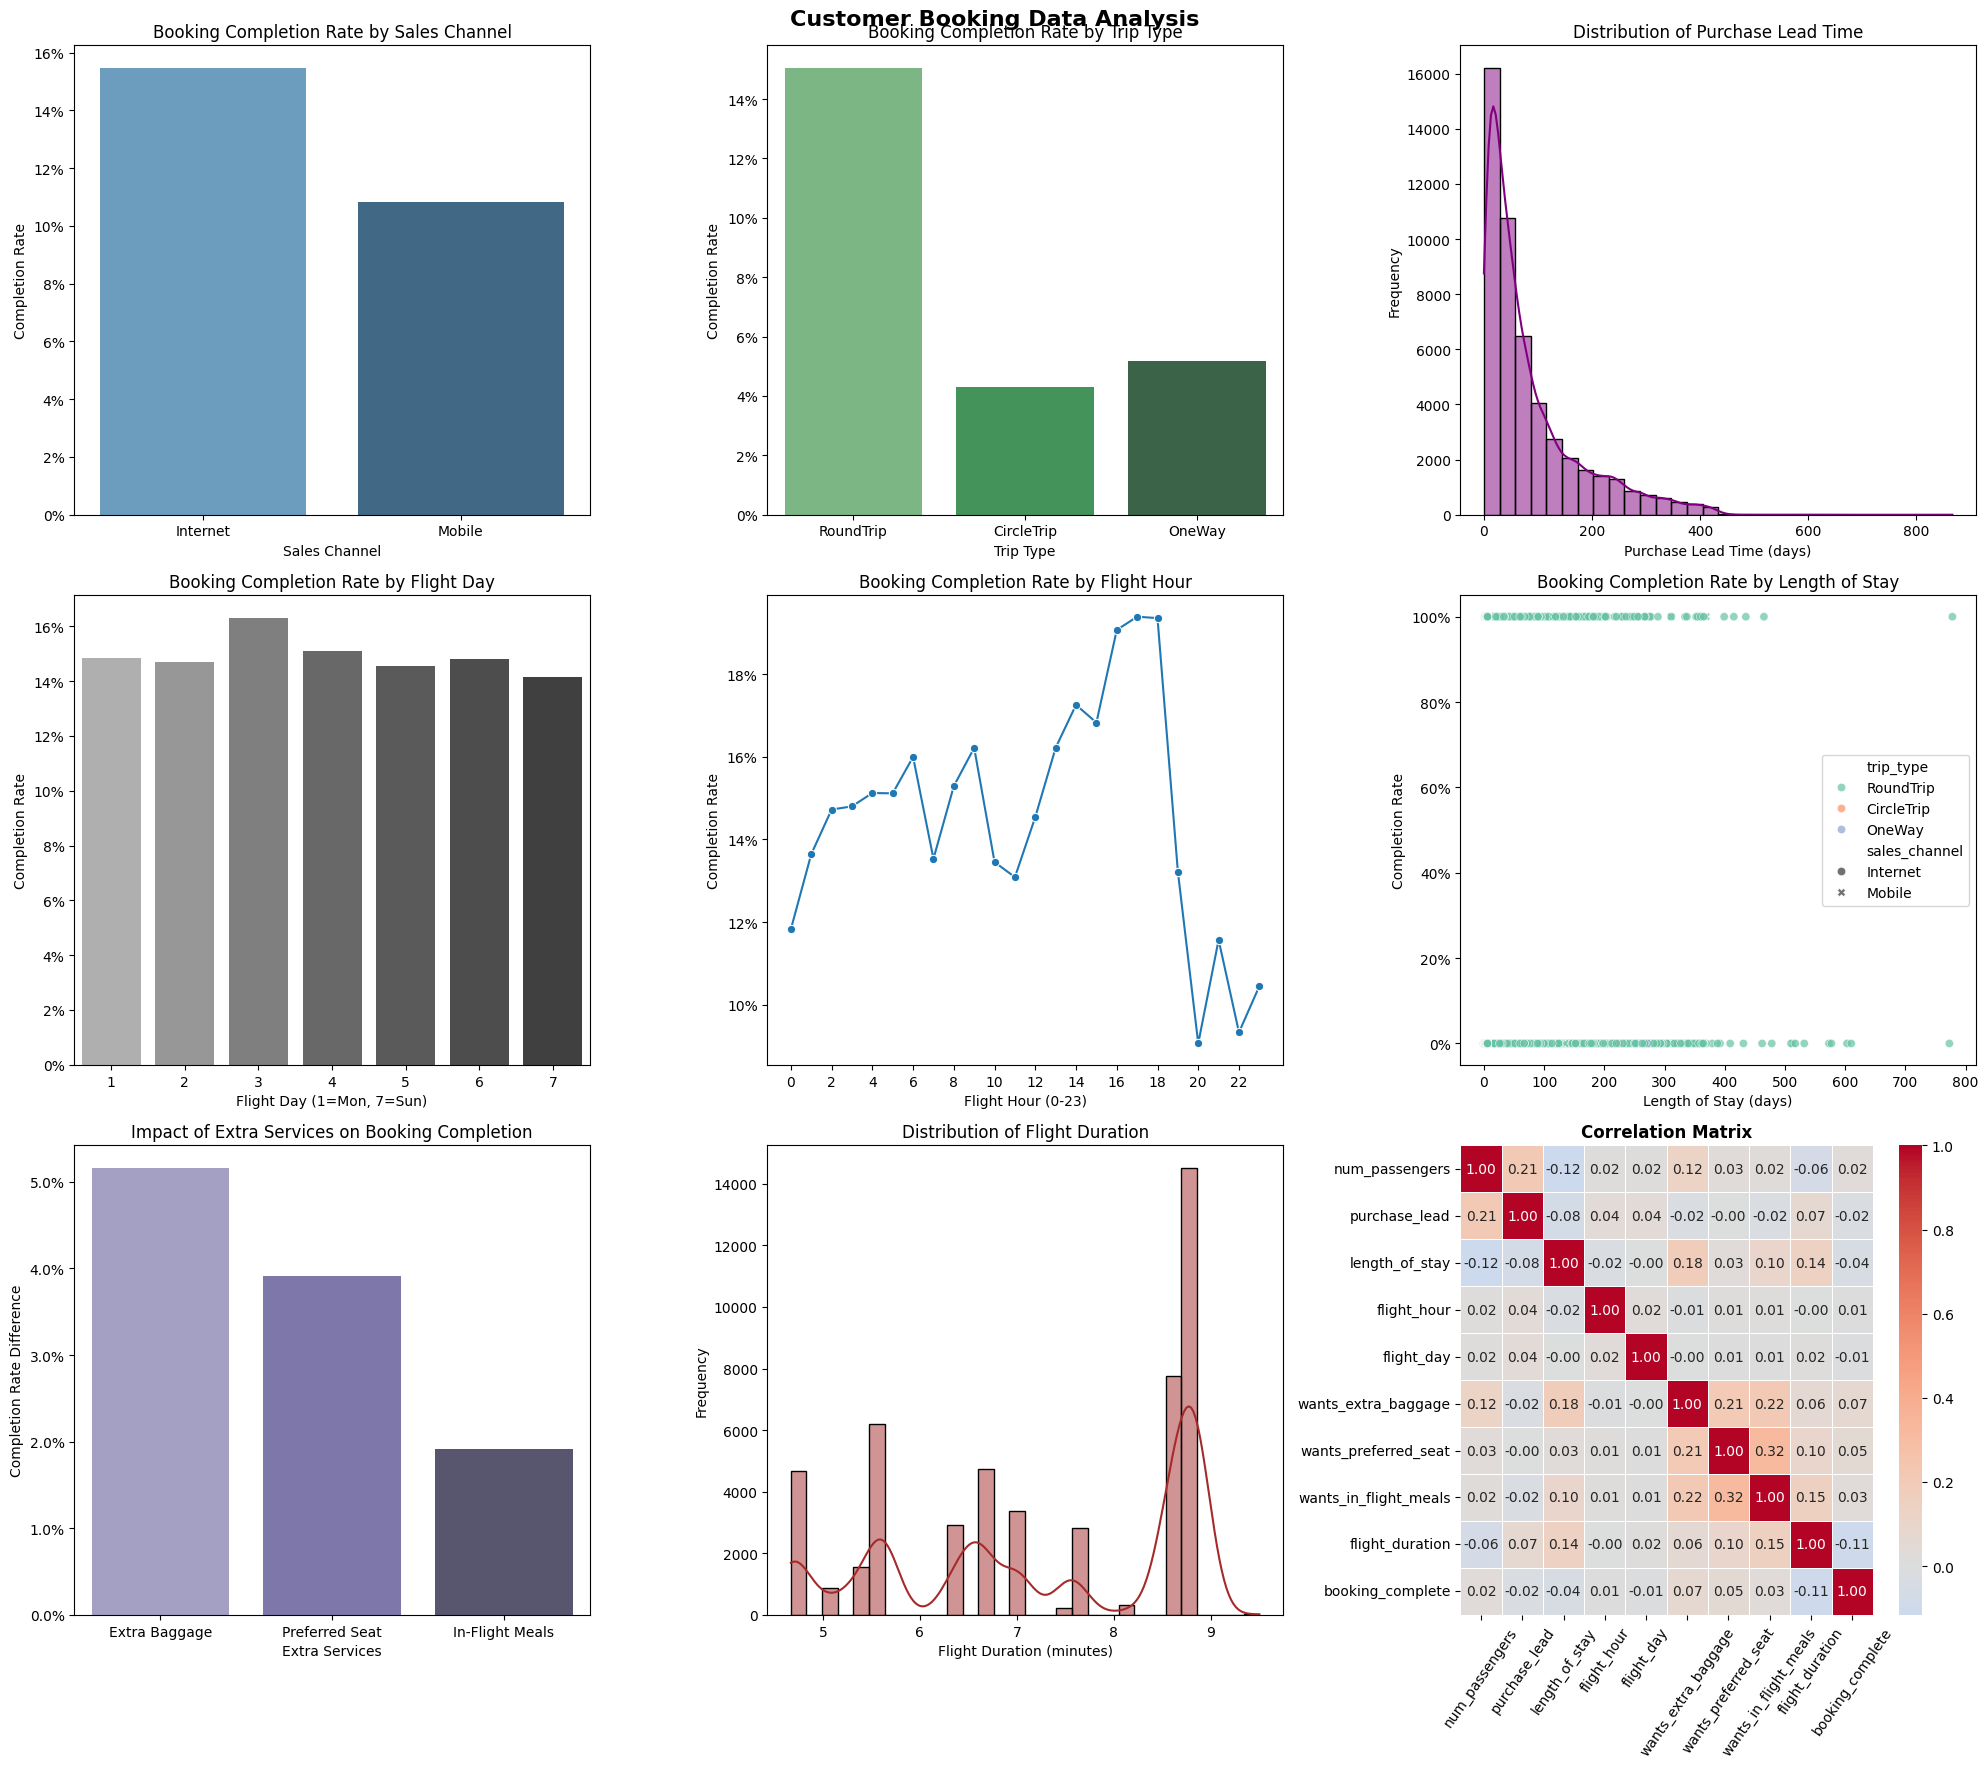

In [10]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Customer Booking Data Analysis', fontsize=16, fontweight='bold')

# 1. Booking completion rate by sales channel
sns.barplot(
    data=df, 
    x='sales_channel', 
    y='booking_complete', 
    estimator='mean', 
    ci=None, 
    ax=axes[0, 0],
    palette='Blues_d'
)
axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
axes[0, 0].set_title('Booking Completion Rate by Sales Channel')
axes[0, 0].set_ylabel('Completion Rate')
axes[0, 0].set_xlabel('Sales Channel')



# 2. Booking completion by trip type
sns.barplot(
    data=df, 
    x='trip_type', 
    y='booking_complete', 
    estimator='mean',
    # estimator=lambda x: 100 * x.mean(),  # convert to percentage directly
    ci=None, 
    ax=axes[0, 1],
    palette='Greens_d'
)   
axes[0, 1].set_title('Booking Completion Rate by Trip Type')
axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y *100)))
axes[0, 1].set_ylabel('Completion Rate')
axes[0, 1].set_xlabel('Trip Type')




# 3. Purchase lead time distribution
sns.histplot(
    df['purchase_lead'], 
    bins=30, 
    kde=True, 
    ax=axes[0, 2], 
    color='purple'
)
axes[0, 2].set_title('Distribution of Purchase Lead Time')
axes[0, 2].set_xlabel('Purchase Lead Time (days)')
axes[0, 2].set_ylabel('Frequency')



# 4. Booking completion by flight day
sns.barplot(
    data=df, 
    x='flight_day', 
    y='booking_complete', 
    estimator='mean', 
    ci=None, 
    ax=axes[1, 0],
    palette='Greys_d'
)
axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
axes[1, 0].set_title('Booking Completion Rate by Flight Day')       
axes[1, 0].set_ylabel('Completion Rate')
axes[1, 0].set_xlabel('Flight Day (1=Mon, 7=Sun)')




# 5. Flight hour vs booking completion
sns.lineplot(
    data = df,
    x = 'flight_hour',
    y = 'booking_complete',
    estimator='mean',
    ci=None,
    ax=axes[1, 1],
    marker='o',
    
)
axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
axes[1, 1].set_title('Booking Completion Rate by Flight Hour')
axes[1, 1].set_ylabel('Completion Rate')
axes[1, 1].set_xlabel('Flight Hour (0-23)')
axes[1, 1].set_xticks(range(0, 24, 2))  # Set x-ticks for every 2 hours




# 6. Length of stay vs booking completion
sns.scatterplot(
    data=df,
    x='length_of_stay',
    y='booking_complete',
    hue='trip_type',
    style='sales_channel',
    ax=axes[1, 2],
    palette='Set2',
    alpha=0.7,
    legend='auto'
)
axes[1, 2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
axes[1, 2].set_title('Booking Completion Rate by Length of Stay')
axes[1, 2].set_ylabel('Completion Rate')
axes[1, 2].set_xlabel('Length of Stay (days)')




# 7. Extra services impact
extra_services = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
labels = ['Extra Baggage', 'Preferred Seat', 'In-Flight Meals']
impacts = [
    df.groupby(col)['booking_complete'].mean()[1] - df.groupby(col)['booking_complete'].mean()[0] 
    for col in extra_services
]
# Create a DataFrame for plotting
impact_df = pd.DataFrame({'Service': labels, 'Impact': impacts})

# Plot using Seaborn
sns.barplot(
    data=impact_df,
    x='Service',
    y='Impact',
    palette='Purples_d',
    ax=axes[2, 0]
)
axes[2, 0].set_title('Impact of Extra Services on Booking Completion')
axes[2, 0].set_ylabel('Completion Rate Difference')
axes[2, 0].set_xlabel('Extra Services')
axes[2, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.1f}%'))  # Convert to %




# 8. Flight duration distribution
sns.histplot(
    df['flight_duration'], 
    bins=30, 
    kde=True, 
    ax=axes[2, 1], 
    color='brown'
)   
axes[2, 1].set_title('Distribution of Flight Duration')
axes[2, 1].set_xlabel('Flight Duration (minutes)')
axes[2, 1].set_ylabel('Frequency')




# 9. Correlation heatmap
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',                 # limit decimals
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='white',
    ax=axes[2, 2]
)
axes[2, 2].set_title('Correlation Matrix', fontsize=12, fontweight='bold')
axes[2, 2].tick_params(axis='x', rotation=55)
axes[2, 2].tick_params(axis='y', rotation=0)

plt.tight_layout()

## Feature Engineering


In [11]:
# Create a copy for preprocessing
df_model = df.copy()

In [12]:
# Feature 1: Purchase lead time categories
df_model['purchase_lead_category'] = pd.cut(df_model['purchase_lead'], 
                                           bins=[0, 7, 30, 90, 1000], 
                                           labels=['Last_minute', 'Short_term', 'Medium_term', 'Long_term'])

# Feature 2: Length of stay categories
df_model['stay_category'] = pd.cut(df_model['length_of_stay'], 
                                  bins=[0, 7, 14, 30, 1000], 
                                  labels=['Short', 'Medium', 'Long', 'Extended'])

# Feature 3: Flight time categories
df_model['flight_time_category'] = pd.cut(df_model['flight_hour'], 
                                         bins=[0, 6, 12, 18, 24], 
                                         labels=['Early_morning', 'Morning', 'Afternoon', 'Evening'])

# Feature 4: Total extra services
df_model['total_extras'] = (df_model['wants_extra_baggage'] + 
                           df_model['wants_preferred_seat'] + 
                           df_model['wants_in_flight_meals'])

# Feature 5: Weekend flight indicator
df_model['is_weekend'] = df_model['flight_day'].isin([6, 7]).astype(int)

# Feature 6: High passenger count
df_model['high_passenger_count'] = (df_model['num_passengers'] > 2).astype(int)

# Feature 7: Long haul flight indicator
df_model['is_long_haul'] = (df_model['flight_duration'] > 7).astype(int)

print("New features created:")
print("- purchase_lead_category")
print("- stay_category") 
print("- flight_time_category")
print("- total_extras")
print("- is_weekend")
print("- high_passenger_count")
print("- is_long_haul")


New features created:
- purchase_lead_category
- stay_category
- flight_time_category
- total_extras
- is_weekend
- high_passenger_count
- is_long_haul


## Data Processing

In [13]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['sales_channel', 'trip_type', 'route', 'booking_origin', 
                   'purchase_lead_category', 'stay_category', 'flight_time_category']

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# Select features for modeling
feature_cols = [
    'num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 
    'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 
    'wants_in_flight_meals', 'flight_duration', 'total_extras', 
    'is_weekend', 'high_passenger_count', 'is_long_haul'
] + [col + '_encoded' for col in categorical_cols]

X = df_model[feature_cols]
y = df_model['booking_complete']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Feature matrix shape: (50000, 20)
Target variable shape: (50000,)


## Model Training and Evaluation

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (40000, 20)
Test set shape: (10000, 20)


In [26]:
# Train Random Forest model

rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20, 
    min_samples_split=5,
    random_state=42, 
    class_weight='balanced'
)
rf.fit(X_train, y_train)
best_rf = rf  
print("Model training completed!")

Model training completed!


In [27]:
# Make predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

In [28]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")



MODEL PERFORMANCE METRICS
Accuracy: 0.8437
Precision: 0.4512
Recall: 0.2595
F1-Score: 0.3295
ROC AUC: 0.7722


In [29]:
# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*50)
print(feature_importance.head(10))



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8520
           1       0.45      0.26      0.33      1480

    accuracy                           0.84     10000
   macro avg       0.67      0.60      0.62     10000
weighted avg       0.82      0.84      0.83     10000


Confusion Matrix:
[[8053  467]
 [1096  384]]

TOP 10 MOST IMPORTANT FEATURES
                           feature  importance
16          booking_origin_encoded    0.172077
15                   route_encoded    0.143959
1                    purchase_lead    0.131023
2                   length_of_stay    0.099646
3                      flight_hour    0.091162
8                  flight_duration    0.067938
4                       flight_day    0.060010
0                   num_passengers    0.033193
19    flight_time_category_encoded    0.032194
17  purchase_lead_category_encoded    0.031028


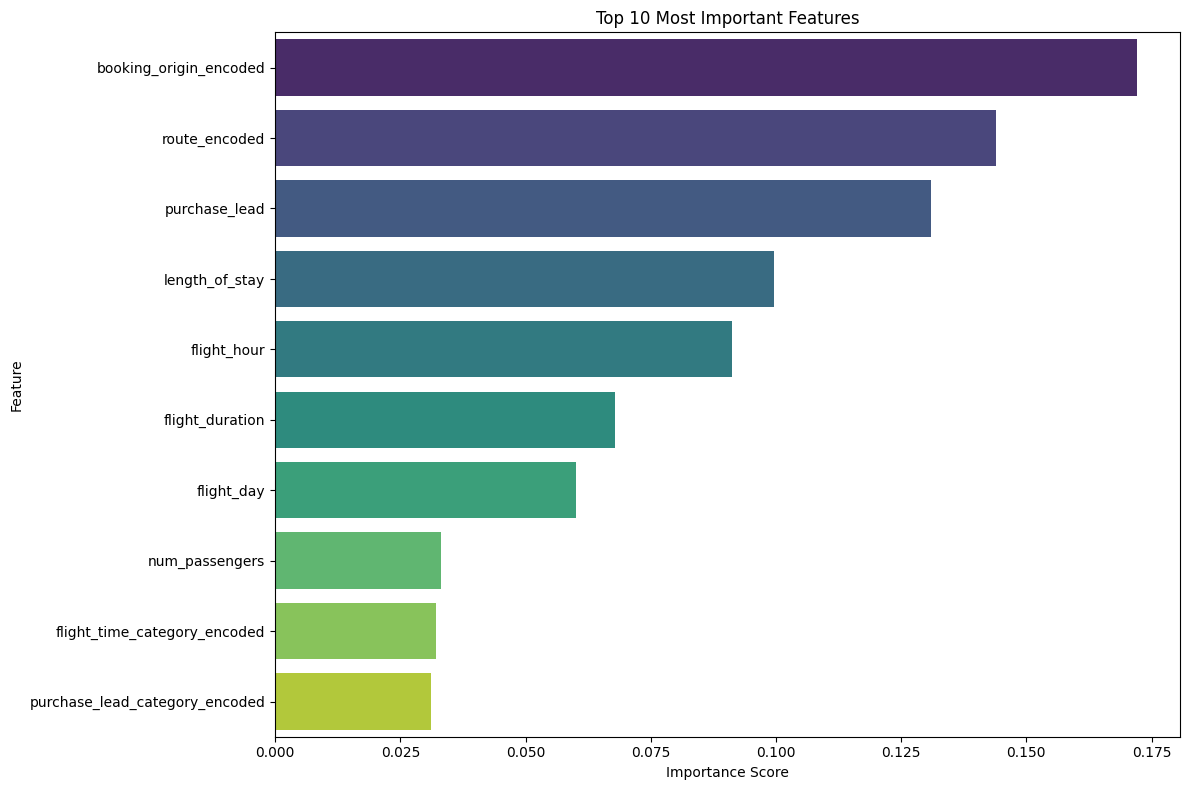

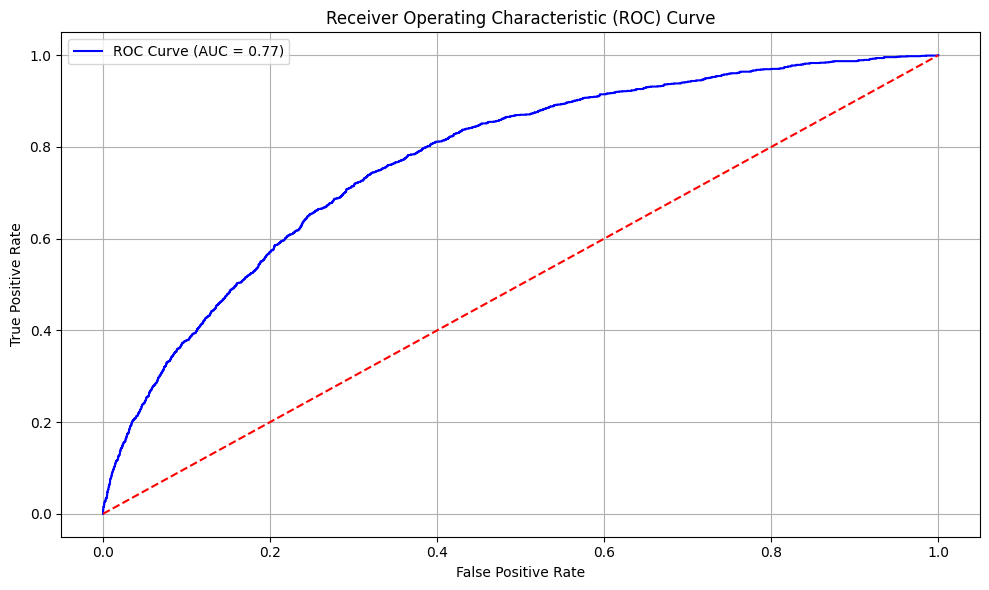

In [30]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance.head(10), 
    palette='viridis'
)
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [19]:
# Sequential Parameter Tuning 
# This approach tunes one parameter at a time, making it much faster and less resource-intensive

print("="*60)
print("ANOTHER APPROACH : SEQUENTIAL HYPERPARAMETER TUNING")
print("="*60)

# Step 1: Tune n_estimators first
print("\nStep 1: Tuning n_estimators...")
n_estimators_range = [50, 100, 150, 200, 250, 300]
best_score = 0
best_n_estimators = 100

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    )
    
    # Use 3-fold CV to speed up
    cv_scores = cross_val_score(rf_temp, X_train, y_train, cv=3, scoring='roc_auc')
    avg_score = cv_scores.mean()
    
    print(f"n_estimators={n_est}: ROC AUC = {avg_score:.4f}")
    
    if avg_score > best_score:
        best_score = avg_score
        best_n_estimators = n_est

print(f"Best n_estimators: {best_n_estimators} (ROC AUC: {best_score:.4f})")


ANOTHER APPROACH : SEQUENTIAL HYPERPARAMETER TUNING

Step 1: Tuning n_estimators...
n_estimators=50: ROC AUC = 0.7508
n_estimators=100: ROC AUC = 0.7561
n_estimators=150: ROC AUC = 0.7583
n_estimators=200: ROC AUC = 0.7590
n_estimators=250: ROC AUC = 0.7601
n_estimators=300: ROC AUC = 0.7604
Best n_estimators: 300 (ROC AUC: 0.7604)


In [20]:

# Step 2: Tune max_depth with best n_estimators
print("\nStep 2: Tuning max_depth...")
max_depth_range = [10, 15, 20, 25, 30, None]
best_score = 0
best_max_depth = 20

for max_d in max_depth_range:
    rf_temp = RandomForestClassifier(
        n_estimators=best_n_estimators,
        max_depth=max_d,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    )
    
    cv_scores = cross_val_score(rf_temp, X_train, y_train, cv=3, scoring='roc_auc')
    avg_score = cv_scores.mean()
    
    print(f"max_depth={max_d}: ROC AUC = {avg_score:.4f}")
    
    if avg_score > best_score:
        best_score = avg_score
        best_max_depth = max_d

print(f"Best max_depth: {best_max_depth} (ROC AUC: {best_score:.4f})")



Step 2: Tuning max_depth...
max_depth=10: ROC AUC = 0.7570
max_depth=15: ROC AUC = 0.7597
max_depth=20: ROC AUC = 0.7604
max_depth=25: ROC AUC = 0.7592
max_depth=30: ROC AUC = 0.7596
max_depth=None: ROC AUC = 0.7594
Best max_depth: 20 (ROC AUC: 0.7604)


In [21]:

# Step 3: Tune min_samples_split
print("\nStep 3: Tuning min_samples_split...")
min_samples_split_range = [2, 5, 10, 15, 20]
best_score = 0
best_min_samples_split = 5

for min_split in min_samples_split_range:
    rf_temp = RandomForestClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_split=min_split,
        random_state=42,
        class_weight='balanced'
    )
    
    cv_scores = cross_val_score(rf_temp, X_train, y_train, cv=3, scoring='roc_auc')
    avg_score = cv_scores.mean()
    
    print(f"min_samples_split={min_split}: ROC AUC = {avg_score:.4f}")
    
    if avg_score > best_score:
        best_score = avg_score
        best_min_samples_split = min_split

print(f"Best min_samples_split: {best_min_samples_split} (ROC AUC: {best_score:.4f})")



Step 3: Tuning min_samples_split...
min_samples_split=2: ROC AUC = 0.7580
min_samples_split=5: ROC AUC = 0.7604
min_samples_split=10: ROC AUC = 0.7637
min_samples_split=15: ROC AUC = 0.7658
min_samples_split=20: ROC AUC = 0.7652
Best min_samples_split: 15 (ROC AUC: 0.7658)


In [22]:

# Step 4: Tune min_samples_leaf
print("\nStep 4: Tuning min_samples_leaf...")
min_samples_leaf_range = [1, 2, 4, 6, 8]
best_score = 0
best_min_samples_leaf = 1

for min_leaf in min_samples_leaf_range:
    rf_temp = RandomForestClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_split=best_min_samples_split,
        min_samples_leaf=min_leaf,
        random_state=42,
        class_weight='balanced'
    )
    
    cv_scores = cross_val_score(rf_temp, X_train, y_train, cv=3, scoring='roc_auc')
    avg_score = cv_scores.mean()
    
    print(f"min_samples_leaf={min_leaf}: ROC AUC = {avg_score:.4f}")
    
    if avg_score > best_score:
        best_score = avg_score
        best_min_samples_leaf = min_leaf

print(f"Best min_samples_leaf: {best_min_samples_leaf} (ROC AUC: {best_score:.4f})")



Step 4: Tuning min_samples_leaf...


min_samples_leaf=1: ROC AUC = 0.7658
min_samples_leaf=2: ROC AUC = 0.7649
min_samples_leaf=4: ROC AUC = 0.7656
min_samples_leaf=6: ROC AUC = 0.7658
min_samples_leaf=8: ROC AUC = 0.7653
Best min_samples_leaf: 1 (ROC AUC: 0.7658)


In [23]:

# Train final model with best parameters
print("\n" + "="*60)
print("FINAL TUNED MODEL")
print("="*60)

best_rf_tuned = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42,
    class_weight='balanced'
)

print("Training final tuned model...")
best_rf_tuned.fit(X_train, y_train)

# Make predictions with tuned model
y_pred_tuned = best_rf_tuned.predict(X_test)
y_pred_proba_tuned = best_rf_tuned.predict_proba(X_test)[:, 1]

# Calculate performance metrics for tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"\nFinal tuned model parameters:")
print(f"- n_estimators: {best_n_estimators}")
print(f"- max_depth: {best_max_depth}")
print(f"- min_samples_split: {best_min_samples_split}")
print(f"- min_samples_leaf: {best_min_samples_leaf}")



FINAL TUNED MODEL
Training final tuned model...

Final tuned model parameters:
- n_estimators: 300
- max_depth: 20
- min_samples_split: 15
- min_samples_leaf: 1


In [24]:
print("\n" + "="*50)
print("TUNED MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"ROC AUC: {roc_auc_tuned:.4f}")

# Compare with baseline (assuming you have these from previous run)
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print("Metric      | Baseline | Tuned   | Improvement")
print("-" * 45)
print(f"Accuracy    | 0.8437   | {accuracy_tuned:.4f} | {accuracy_tuned - 0.8437:+.4f}")
print(f"Precision   | 0.4512   | {precision_tuned:.4f} | {precision_tuned - 0.4512:+.4f}")
print(f"Recall      | 0.2595   | {recall_tuned:.4f} | {recall_tuned - 0.2595:+.4f}")
print(f"F1-Score    | 0.3295   | {f1_tuned:.4f} | {f1_tuned - 0.3295:+.4f}")
print(f"ROC AUC     | 0.7722   | {roc_auc_tuned:.4f} | {roc_auc_tuned - 0.7722:+.4f}")

# Cross-validation for final model
cv_scores_tuned = cross_val_score(best_rf_tuned, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nTuned model CV ROC AUC: {cv_scores_tuned.mean():.4f} (+/- {cv_scores_tuned.std() * 2:.4f})")

print("\nHyperparameter tuning completed!")


TUNED MODEL PERFORMANCE METRICS
Accuracy: 0.8181
Precision: 0.3925
Recall: 0.4182
F1-Score: 0.4050
ROC AUC: 0.7817

PERFORMANCE COMPARISON
Metric      | Baseline | Tuned   | Improvement
---------------------------------------------
Accuracy    | 0.8437   | 0.8181 | -0.0256
Precision   | 0.4512   | 0.3925 | -0.0587
Recall      | 0.2595   | 0.4182 | +0.1587
F1-Score    | 0.3295   | 0.4050 | +0.0755
ROC AUC     | 0.7722   | 0.7817 | +0.0095

Tuned model CV ROC AUC: 0.7661 (+/- 0.0277)

Hyperparameter tuning completed!



TOP 10 MOST IMPORTANT FEATURES (TUNED MODEL)
                         feature  importance
16        booking_origin_encoded    0.207721
15                 route_encoded    0.147102
1                  purchase_lead    0.120541
2                 length_of_stay    0.095630
3                    flight_hour    0.080973
8                flight_duration    0.070272
4                     flight_day    0.051271
0                 num_passengers    0.029463
19  flight_time_category_encoded    0.027611
9                   total_extras    0.027370


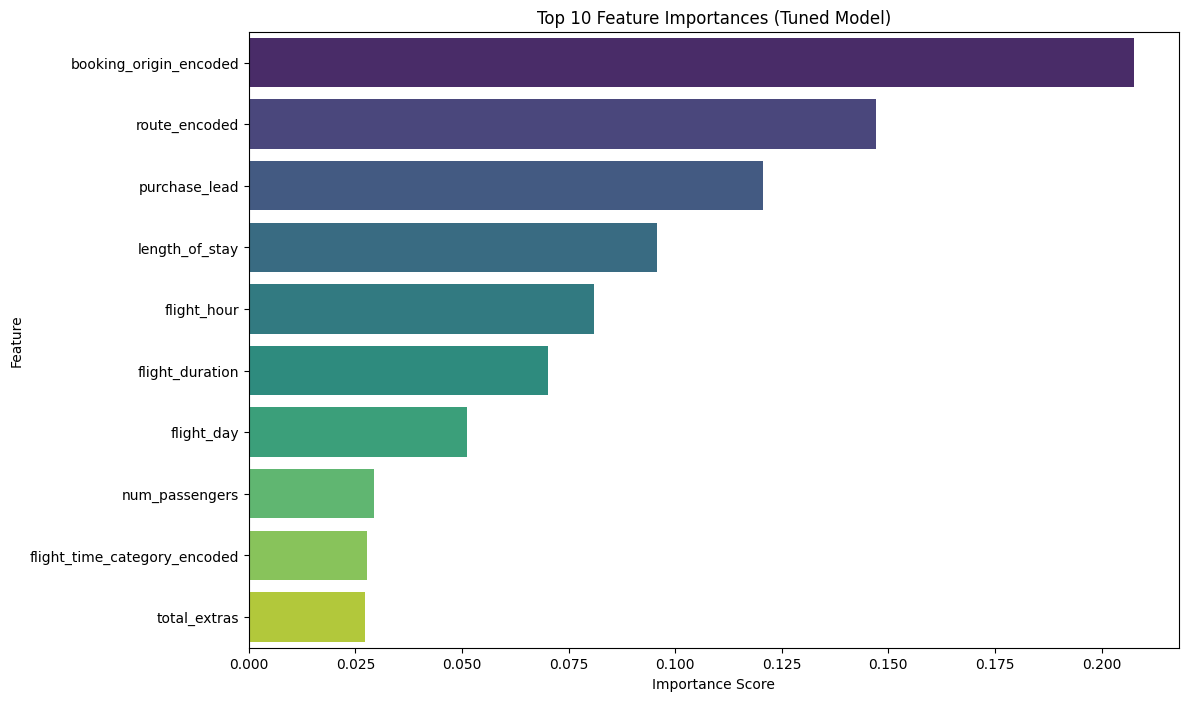

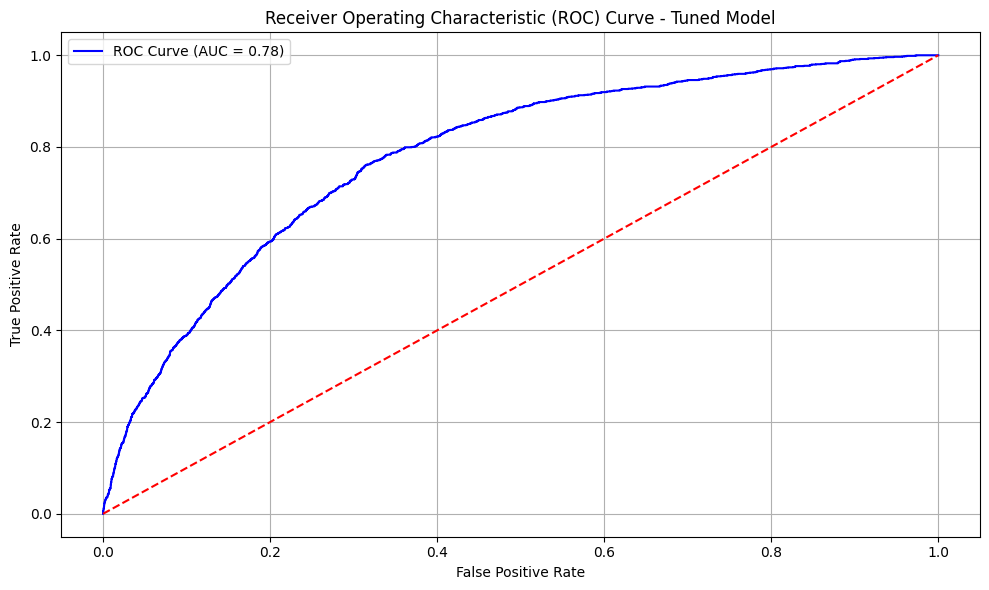

In [31]:
# Feature importance analysis
feature_importance_tuned = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)
print("\n" + "="*50)
print("TOP 10 MOST IMPORTANT FEATURES (TUNED MODEL)")
print("="*50)
print(feature_importance_tuned.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feature_importance_tuned.head(10),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title('Top 10 Feature Importances (Tuned Model)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
# Plot ROC Curve for tuned model
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_proba_tuned)
plt.figure(figsize=(10, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc_tuned))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve - Tuned Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
